# Clase 5

# Introducción a Transformers

En este veremos una introducción práctica al uso de transformers para tareas multimodales, específicamente Visual Question Answering (VQA). Integra técnicas de visión por computadora y procesamiento del lenguaje natural para responder preguntas sobre imágenes. Incluye la descarga y manejo de un dataset de VQA, el uso del modelo BLIP para generar respuestas y funciones auxiliares para cargar, procesar imágenes y visualizar resultados.

In [3]:
# trasnformes
!pip install transformers huggingface-hub
!pip install datasets
!pip install --upgrade datasets
!pip install --upgrade transformers

# librerias extras
!pip install pillow matplotlib requests
!pip install --upgrade Pillow

# evitar warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="transformers.generation.utils")
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers")


# Dataset VQA

¿Qué es Visual Question Answering (VQA)?

VQA es una tarea que combina visión por computadora y NLP para responder preguntas basadas en el contenido de una imagen. Ejemplos comunes incluyen:
- "¿Qué objeto se encuentra en la imagen?"
- "¿Qué texto aparece en el letrero?"

In [4]:
import gdown
#https://drive.google.com/file/d/17C0RkHlUG3Ymn8SK3bBupC7NqvN1eGqf/view?usp=sharing
#TextVQA_0.5.1_train.json

#TextVQA_0.5.1_test.json
#https://drive.google.com/file/d/1LmrYyUsyLmcswQGHbP9bcF7744l_IiL_/view?usp=sharing

print("Descargando dataset...")
url = 'https://drive.google.com/uc?export=download&id=17C0RkHlUG3Ymn8SK3bBupC7NqvN1eGqf'
destination = "TextVQA_0.5.1_train.json"
gdown.download(url, destination, quiet=False)

Descargando dataset...


Downloading...
From: https://drive.google.com/uc?export=download&id=17C0RkHlUG3Ymn8SK3bBupC7NqvN1eGqf
To: /content/TextVQA_0.5.1_train.json
100%|██████████| 21.6M/21.6M [00:00<00:00, 133MB/s] 


'TextVQA_0.5.1_train.json'

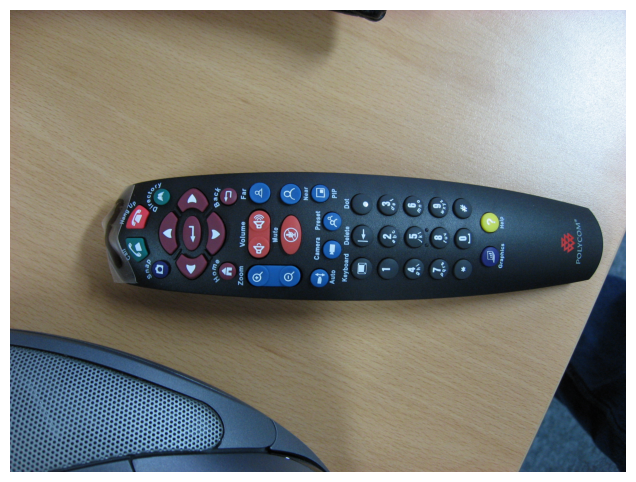

Pregunta: what symbol is on the yellow button?
Respuestas posibles: ['info', '?', 'question mark (?)', 'answering does not require reading text in the image', 'question mark', '?', 'a question mark.', '?', 'question mark', 'question mark  (?)']
Respuesta final más probable: ?


In [17]:
#@title Exploramos el dataset

import os
import json
import random
import requests
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from transformers import BlipProcessor, BlipForQuestionAnswering
from io import BytesIO
import time


def cargar_dataset(ruta_json):
    with open(ruta_json, 'r') as f:
        data = json.load(f)
    return data['data']

# Función para obtener un ejemplo aleatorio
def obtener_ejemplo_aleatorio(dataset,ruta_imagenes):
    while True:
        ejemplo = random.choice(dataset)
        img, image_path = obtener_imagen(ejemplo, ruta_imagenes)
        if img is not None:
            return ejemplo, img, image_path
        else:
            print("Intentando con otro ejemplo debido a imagen no disponible.")

def verificar_directorio(ruta):
    if not os.path.exists(ruta):
        os.makedirs(ruta)

# Función para obtener la imagen
# Función para obtener la imagen
def obtener_imagen(ejemplo, ruta_imagenes):
    verificar_directorio(ruta_imagenes)
    image_id = ejemplo['image_id']
    image_path = os.path.join(ruta_imagenes, f"{image_id}.jpg")

    try:
        if os.path.exists(image_path):
            img = Image.open(image_path).convert('RGB')
        else:
            response = requests.get(ejemplo['flickr_original_url'], timeout=20)
            if response.status_code == 200:
                img = Image.open(BytesIO(response.content)).convert('RGB')
                img.save(image_path)
            else:
                print(f"No se pudo descargar la imagen desde {ejemplo['flickr_original_url']}. Código de estado: {response.status_code}")
                return None, None
        return img, image_path
    except requests.exceptions.RequestException as e:
        print(f"Error de red al descargar la imagen: {e}")
        return None, None
    except Image.UnidentifiedImageError:
        print(f"Error: La imagen descargada no es válida.")
        return None, None
    except Exception as e:
        print(f"Error general al procesar la imagen: {e}")
        return None, None

def calcular_respuesta_mas_frecuente(ejemplo):
    respuestas_posibles = ejemplo.get('answers', [])
    if respuestas_posibles:
        respuesta_final = Counter(respuestas_posibles).most_common(1)[0][0]
    else:
        respuesta_final = "No hay respuestas disponibles"
    return respuesta_final

def mostrar_ejemplo(ejemplo, img):
    if img is not None:
        # Mostrar la imagen
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
        print("Imagen no disponible.")

    # Mostrar la pregunta y la respuesta más frecuente
    respuestas_posibles = ejemplo.get('answers', [])
    respuesta_final = calcular_respuesta_mas_frecuente(ejemplo)
    pregunta = ejemplo['question']

    print(f"Pregunta: {ejemplo['question']}")
    print(f"Respuestas posibles: {respuestas_posibles}")
    print(f"Respuesta final más probable: {respuesta_final}")
    return pregunta, respuesta_final


def ejecutar_ejemplo():

    # Cargar el dataset
    dataset = cargar_dataset(ruta_json)

    # Obtener un ejemplo aleatorio con imagen disponible
    ejemplo, img, image_path = obtener_ejemplo_aleatorio(dataset,ruta_imagenes)

    # Mostrar el ejemplo
    mostrar_ejemplo(ejemplo, img)

    return ejemplo, img

if __name__ == "__main__":
    ruta_json = '/content/TextVQA_0.5.1_train.json'
    ruta_imagenes = '/content/TextVQA/train_images'
    ejemplo, img = ejecutar_ejemplo()


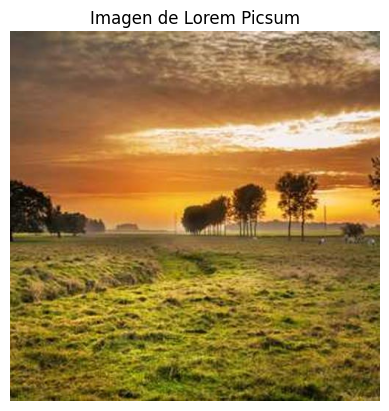

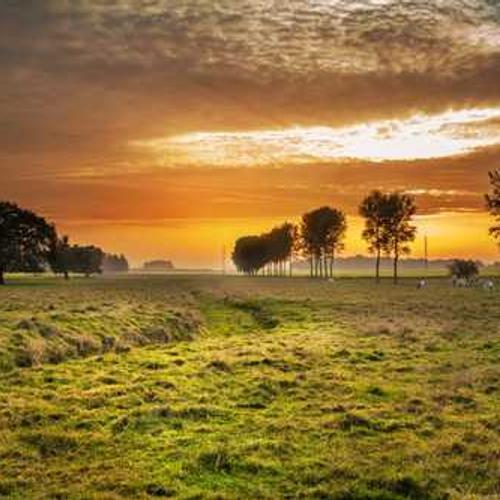

In [6]:
# Esta funcion obtine una imagen aleatoria del repo: picsum
import requests
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

def ejemplo_picsum():
  # URL de una imagen aleatoria de Lorem Picsum
  url = "https://picsum.photos/500/500"
  response = requests.get(url)

  # Verificar si la descarga fue exitosa
  if response.status_code == 200:
      image = Image.open(BytesIO(response.content)).convert('RGB')  # Convertir a RGB para evitar errores

      # Mostrar la imagen usando Matplotlib
      plt.imshow(image)
      plt.axis('off')  # Ocultar los ejes
      plt.title("Imagen de Lorem Picsum")
      plt.show()
      return image
  else:
      raise ValueError(f"Error al descargar la imagen: {response.status_code}")
      return None

ejemplo_picsum()

# 1) Aplicar modelos image-captioning

Permiten obtener la descripcion dada una imagen

In [ ]:
#@title TODO 1: Inferencia de descripciones usando imagenes

### TODO 1:  Aplicar a la imagen anterior
# pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")
# Mostrar descripcion creada por el modelo
# ¿Le parece acertada la descripcion creada?

In [13]:
#@title solución

from transformers import BlipProcessor, BlipForQuestionAnswering, pipeline

def describir_imagen(img):
    """
    Genera una descripción textual de la imagen usando un modelo preentrenado.
    """
    try:
        image_to_text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")
        result = image_to_text(img)
        return result[0]['generated_text']
    except Exception as e:
        print(f"Error al describir la imagen: {e}")
        return "Descripción no disponible"
        return result
descripcion_imagen = describir_imagen(img)

print(f"Descripción generada de la imagen: {descripcion_imagen}")

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

Descripción generada de la imagen: a baseball player is jumping up to catch a ball 


# 2) Modelos BLIP

Permiten obtener la descripcion dada una imagen y un texto


### ¿Qué es el modelo BLIP?

BLIP (Bootstrapped Language-Image Pre-training) es un modelo avanzado de **visión-lenguaje** desarrollado para tareas de razonamiento que combinan texto e imágenes, como **Visual Question Answering (VQA)**, **Image Captioning** y **Image-Text Retrieval**.

### ¿Cómo funciona BLIP?

BLIP combina la **visión** y el **lenguaje** utilizando una arquitectura basada en **Transformers**, que son la base de modelos como BERT y GPT. Los Transformers permiten a BLIP analizar imágenes y texto conjuntamente, aprendiendo representaciones ricas y profundas que comprenden tanto el contenido visual como el textual.

### ¿Por qué es importante?

BLIP es importante porque:
- Puede responder preguntas sobre imágenes (VQA).
- Genera descripciones precisas de imágenes (Captioning).
- Encuentra relaciones entre imágenes y textos, mejorando la búsqueda y clasificación.

### Transformers

BLIP utiliza Transformers tanto para procesar texto (como preguntas o descripciones) como para extraer características de las imágenes. Este enfoque unificado lo hace extremadamente potente para tareas multimodales, donde la combinación de información visual y textual es clave.

### Aplicaciones

- **Medicina**: Analizar imágenes médicas y generar descripciones clínicas.
- **Educación**: Crear herramientas interactivas que combinen texto e imágenes.
- **Seguridad**: Reconocimiento y descripción de escenas.

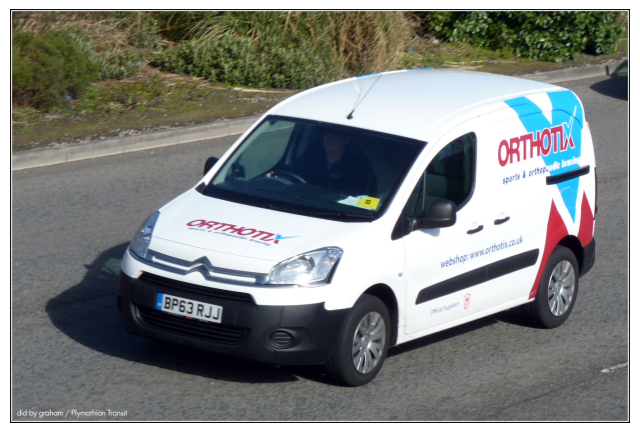

Pregunta: what company does this van belong to?
Respuestas posibles: ['orthotix', 'orthotx', 'orthotix', 'orthotix', 'orthotix', 'orthotix', 'orthotix ', 'orthotix', 'orthotix', 'orthoti']
Respuesta final más probable: orthotix
Cargando el modelo: Salesforce/blip-vqa-base


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]


 Respuesta generada: citroen


In [8]:
import os
import json
import random
import requests
from PIL import Image
import matplotlib.pyplot as plt
from transformers import BlipProcessor, BlipForQuestionAnswering
from io import BytesIO

# Cargar modelo
def cargar_modelo(nombre_modelo):
    """
    Carga un modelo y su procesador para responder preguntas sobre imágenes.
    """
    try:
        print(f"Cargando el modelo: {nombre_modelo}")
        # Carga el procesador necesario para preprocesar imágenes y preguntas (tokenización y transformaciones).
        # Carga el modelo preentrenado para responder preguntas basadas en imágenes.
        processor = BlipProcessor.from_pretrained(nombre_modelo)
        model = BlipForQuestionAnswering.from_pretrained(nombre_modelo)
        return processor, model
    except Exception as e:
        print(f"Error al cargar el modelo {nombre_modelo}: {e}")
        return None, None

# Predecir respuestas
def predecir_respuestas(ejemplo, img, processor, model):
    """
    Utiliza el modelo para predecir la respuesta a la pregunta de un ejemplo.
    """
    try:
        inputs = processor(images=img, text=ejemplo['question'], return_tensors="pt")
        output = model.generate(input_ids=inputs['input_ids'], pixel_values=inputs['pixel_values'])
        respuesta_generada = processor.decode(output[0], skip_special_tokens=True)
        print(f"\n Respuesta generada: {respuesta_generada}")
    except Exception as e:
        print(f"Error al predecir la respuesta: {e}")

# Flujo principal
def ejecutar_ejemplo():

    modelo = "Salesforce/blip-vqa-base"

    # Cargar el dataset
    dataset = cargar_dataset(ruta_json)

    # Obtener un ejemplo aleatorio
    ejemplo, img, image_path = obtener_ejemplo_aleatorio(dataset, ruta_imagenes)

    # Mostrar ejemplo
    mostrar_ejemplo(ejemplo, img)

    # Cargar el modelo
    processor, model = cargar_modelo(modelo)

    if processor and model:
        # Predecir respuesta
        predecir_respuestas(ejemplo, img, processor, model)

if __name__ == "__main__":
    ejecutar_ejemplo()


In [ ]:
#@title TODO 2:  Usar el modelo "dandelin/vilt-b32-finetuned-vqa"
# ¿Cree que funciona mejor con ese modelo o no ?

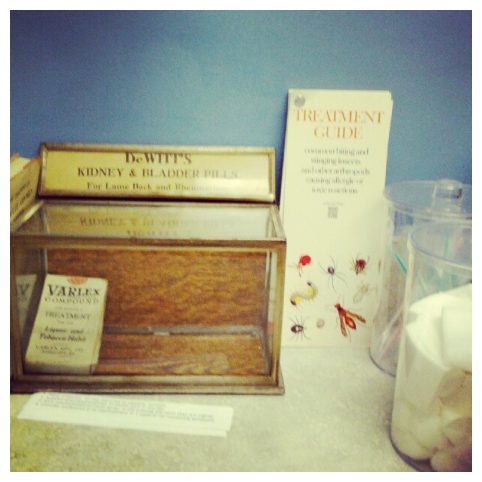

Pregunta: what is advertised on the box?
Respuestas posibles: ['dewitts', 'kidney and bladder pills', 'kidney and bladder pills', 'kidney & bladder pills', 'kidney and bladder pills', 'kidney and bladder pills', 'kidney and bladder pills', 'de witts kidney & bladder pills', "dewitt's kidney and bladder pills", 'kidney and bladder pills']
Respuesta final más probable: kidney and bladder pills

Probando modelo: Salesforce/blip-vqa-base
Cargando el modelo: Salesforce/blip-vqa-base


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Predicciones para el modelo Salesforce/blip-vqa-base:


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(



Respuesta generada: jewelry

Probando modelo: dandelin/vilt-b32-finetuned-vqa
Cargando el modelo: dandelin/vilt-b32-finetuned-vqa
Predicciones para el modelo dandelin/vilt-b32-finetuned-vqa:

Respuesta generada: nothing

Probando modelo: Salesforce/blip-vqa-large
Cargando el modelo: Salesforce/blip-vqa-large
Error al cargar el modelo Salesforce/blip-vqa-large: Salesforce/blip-vqa-large is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`
El modelo Salesforce/blip-vqa-large no se cargó correctamente.

Probando modelo: dandelin/vilt-b16-finetuned-vqa
Cargando el modelo: dandelin/vilt-b16-finetuned-vqa
Error al cargar el modelo dandelin/vilt-b16-finetuned-vqa: dandelin/vilt-b16-finetuned-vqa is not a local folder and is not a valid model identifier listed on 'https://hu

In [1]:
#@title solución

import os
import json
import random
import requests
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from transformers import (
    BlipProcessor, BlipForQuestionAnswering,
    ViltProcessor, ViltForQuestionAnswering,
    DonutProcessor, VisionEncoderDecoderModel,
    # mas
)
from io import BytesIO
import time


def cargar_dataset(ruta_json):
    with open(ruta_json, 'r') as f:
        data = json.load(f)
    if 'data' in data and data['data']:
        return data['data']
    else:
        print("El dataset está vacío o no tiene la clave 'data'.")
        return None

# Función para obtener un ejemplo aleatorio
def obtener_ejemplo_aleatorio(dataset, ruta_imagenes):
    while True:
        ejemplo = random.choice(dataset)
        img, image_path = obtener_imagen(ejemplo, ruta_imagenes)
        if img is not None:
            return ejemplo, img, image_path
        else:
            print("Intentando con otro ejemplo debido a imagen no disponible.")

def verificar_directorio(ruta):
    if not os.path.exists(ruta):
        os.makedirs(ruta)

# Función para obtener la imagen
def obtener_imagen(ejemplo, ruta_imagenes):
    verificar_directorio(ruta_imagenes)
    image_id = ejemplo['image_id']
    image_path = os.path.join(ruta_imagenes, f"{image_id}.jpg")

    try:
        if os.path.exists(image_path):
            img = Image.open(image_path).convert('RGB')
        else:
            response = requests.get(ejemplo['flickr_original_url'], timeout=20)
            if response.status_code == 200:
                img = Image.open(BytesIO(response.content)).convert('RGB')
                img.save(image_path)
            else:
                print(f"No se pudo descargar la imagen desde {ejemplo['flickr_original_url']}. Código de estado: {response.status_code}")
                return None, None
        return img, image_path
    except requests.exceptions.RequestException as e:
        print(f"Error de red al descargar la imagen: {e}")
        return None, None
    except Image.UnidentifiedImageError:
        print(f"Error: La imagen descargada no es válida.")
        return None, None
    except Exception as e:
        print(f"Error general al procesar la imagen: {e}")
        return None, None

def calcular_respuesta_mas_frecuente(ejemplo):
    respuestas_posibles = ejemplo.get('answers', [])
    if respuestas_posibles:
        respuesta_final = Counter(respuestas_posibles).most_common(1)[0][0]
    else:
        respuesta_final = "No hay respuestas disponibles"
    return respuesta_final

def mostrar_ejemplo(ejemplo, img):
    if img is not None:
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
        print("Imagen no disponible.")

    # Mostrar la pregunta y la respuesta más frecuente
    respuestas_posibles = ejemplo.get('answers', [])
    respuesta_final = calcular_respuesta_mas_frecuente(ejemplo)
    pregunta = ejemplo['question']

    print(f"Pregunta: {ejemplo['question']}")
    print(f"Respuestas posibles: {respuestas_posibles}")
    print(f"Respuesta final más probable: {respuesta_final}")
    return pregunta, respuesta_final

def ejecutar_ejemplo(ruta_json, ruta_imagenes):
    dataset = cargar_dataset(ruta_json)

    # Verificar si el dataset se cargó correctamente
    if dataset is None:
        print("El dataset no se pudo cargar. Verifica la ruta y el formato del archivo.")
        return None, None

    # Obtener un ejemplo aleatorio con imagen disponible
    ejemplo, img, image_path = obtener_ejemplo_aleatorio(dataset, ruta_imagenes)

    # Verificar si se obtuvo un ejemplo válido
    if ejemplo is None or img is None:
        print("No se pudo obtener un ejemplo aleatorio. Verifica el dataset y las rutas de las imágenes.")
        return None, None

    # Mostrar el ejemplo
    mostrar_ejemplo(ejemplo, img)

    return ejemplo, img

def get_processor_model_classes(nombre_modelo):
    if 'blip' in nombre_modelo.lower():
        return BlipProcessor, BlipForQuestionAnswering
    elif 'vilt' in nombre_modelo.lower():
        return ViltProcessor, ViltForQuestionAnswering
    elif 'donut' in nombre_modelo.lower():
        return DonutProcessor, VisionEncoderDecoderModel
    else:
        raise ValueError(f"Tipo de modelo desconocido para el modelo {nombre_modelo}")

def cargar_modelo(nombre_modelo):
    try:
        print(f"Cargando el modelo: {nombre_modelo}")
        processor_class, model_class = get_processor_model_classes(nombre_modelo)
        processor = processor_class.from_pretrained(nombre_modelo)
        model = model_class.from_pretrained(nombre_modelo)
        return processor, model
    except Exception as e:
        print(f"Error al cargar el modelo {nombre_modelo}: {e}")
        return None, None

def predecir_respuestas(ejemplo, img, processor, model, nombre_modelo):
    try:
        if 'blip' in nombre_modelo.lower():
            inputs = processor(images=img, text=ejemplo['question'], return_tensors="pt")
            output = model.generate(**inputs)
            respuesta_generada = processor.decode(output[0], skip_special_tokens=True)
            print(f"\nRespuesta generada: {respuesta_generada}")
        elif 'vilt' in nombre_modelo.lower():
            encoding = processor(img, ejemplo['question'], return_tensors="pt")
            outputs = model(**encoding)
            logits = outputs.logits
            idx = logits.argmax(-1).item()
            respuesta_generada = model.config.id2label[idx]
            print(f"\nRespuesta generada: {respuesta_generada}")
        elif 'donut' in nombre_modelo.lower():
            task_prompt = "<s_docvqa><s_question>{}</s_question><s_answer>".format(ejemplo['question'])
            pixel_values = processor(img, return_tensors="pt").pixel_values
            decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
            outputs = model(pixel_values=pixel_values, decoder_input_ids=decoder_input_ids)
            predicted_ids = outputs.logits.argmax(-1)
            respuesta_generada = processor.tokenizer.decode(predicted_ids[0], skip_special_tokens=True)
            respuesta_generada = respuesta_generada.replace(task_prompt, "").replace("</s>", "").strip()
            print(f"\nRespuesta generada: {respuesta_generada}")
        else:
            print("Modelo no soportado en la función predecir_respuestas.")
    except Exception as e:
        print(f"Error al predecir la respuesta: {e}")

def probar_modelos(ejemplo, img):
    modelos = [
        "Salesforce/blip-vqa-base",
        "dandelin/vilt-b32-finetuned-vqa",
        "Salesforce/blip-vqa-large",
        "dandelin/vilt-b16-finetuned-vqa",
        # Puedemos añadir mas modelos
    ]

    for modelo in modelos:
        print(f"\nProbando modelo: {modelo}")
        try:
            # Cargar el modelo
            processor, model = cargar_modelo(modelo)

            if processor and model:
                # Predecir respuesta
                print(f"Predicciones para el modelo {modelo}:")
                predecir_respuestas(ejemplo, img, processor, model, modelo)
            else:
                print(f"El modelo {modelo} no se cargó correctamente.")

        except Exception as e:
            print(f"Error al probar el modelo {modelo}: {e}")


if __name__ == "__main__":
    ruta_json = '/content/TextVQA_0.5.1_train.json'
    ruta_imagenes = '/content/TextVQA/train_images'

    ejemplo, img = ejecutar_ejemplo(ruta_json, ruta_imagenes)

    if ejemplo is not None and img is not None:
        probar_modelos(ejemplo, img)
    else:
        print("No se pudo ejecutar la prueba de modelos debido a un error al obtener el ejemplo.")


In [ ]:
#@title Buscar modelos

from huggingface_hub import list_models

def obtener_modelos_blip_vqa():
    """
    Obtiene una lista de modelos compatibles con BlipProcessor y BlipForQuestionAnswering,
    relacionados con Visual Question Answering (VQA), desde Hugging Face.
    """
    # Palabras clave específicas para filtrar modelos BLIP y VQA
    blip_keywords = ["blip", "visual-question-answering", "vqa", "Salesforce", "Dandelin", "Microsoft"]
    blip_models = set()

    for keyword in blip_keywords:
        models = list(list_models(search=keyword))
        # Filtrar aquellos que contienen 'blip', 'vqa' o nombres relevantes en el ID del modelo
        blip_models.update(model.modelId for model in models
                           if any(term in model.modelId.lower() for term in ["blip", "vqa", "visualbert", "git", "layoutlm", "donut"]))

    return list(blip_models)

# Llamar a la función y mostrar los modelos encontrados
modelos_blip_vqa = obtener_modelos_blip_vqa()
print(f"Modelos compatibles con BlipProcessor y BlipForQuestionAnswering: {len(modelos_blip_vqa)}")
for modelo in modelos_blip_vqa:
    print(modelo)

# tener en cuenta cada uno viene de un repo que tien sus propias configuraciones

Modelos compatibles con BlipProcessor y BlipForQuestionAnswering: 1312
seitzm97/Fine-tuned-BLIB-VQA
shuda5280/blip-checkpoint1-bdd
toilaluan/Florence-2-base-Yes-No-VQA
PepBun/blip2-opt-2.7b-duski_captioner_customtrainer
oclmodels/vqav2_questions
avatarcontinues/blip1000captions
shaden777/ft-ms-git-base-pokemon-blip-captions
arit98/blip2-opt-2.7b-fashion
abhijithgururaj/blip2-opt-2.7b-french-pre-lora-abhijith
VivekChauhan06/Florence-2-OK-VQA
vamsidulam/vqa_graphcore2
datnguyentien204/BLIP_PretrainVietNamese
Vision-Flan/vision-flan_blip2_xl
m-aliabbas1/Florence-2-FT-path-vqa
satefi/fine-tuned-blip2-opt-2.7b-coco-captions-adapters
Covie/paligemma_vqav2
marwanimroz18/blip-trainer
DanielTC/blip2-opt-6.7b-aeroscapes_train-metacaptions-adapters-4-0.37
mavericklsd/paligemma_vqav2
huggingfaceofSAMI/my-blip-model
rbeauchamp/blip_10k_deduped_5epoch_6batch_5e-05lr_AdamW_2e-2wd
jonastokoliu/image_caption_git-base_pokemon-blip-captions_finetune
Hamza12rdsdsf/blip2-opt-2.7b-onepiece-fine-tuned
hyo370

In [ ]:
#Complementario probar con otro modelo que sea compatible

# 3) Modelos OCR

Este código combina procesamiento de imágenes y texto para responder preguntas visuales (vqa). Utiliza ocr y modelos de lenguaje para generar respuestas.

1. **extracción de texto**: usa ocr (tesseract) para obtener texto de imágenes.
2. **generación de respuestas**: emplea modelos de lenguaje (gpt-2) y visión (donut) para responder.
3. **visualización**: muestra la imagen, la pregunta y las respuestas.

### modelos usados:

### 1. **donut (ocr-free document understanding transformer)**

- interpreta documentos directamente desde la imagen, sin necesidad de ocr.
- ideal para documentos complejos como facturas o recibos.

### 2. **vilt (vision-and-language transformer)**

- combina visión y lenguaje en un solo transformer.
- realiza tareas multimodales como vqa y búsqueda imagen-texto.


In [ ]:
!apt-get update
!apt-get install -y tesseract-ocr
!pip install pytesseract

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,107 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,424 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illinois.edu/ubunt

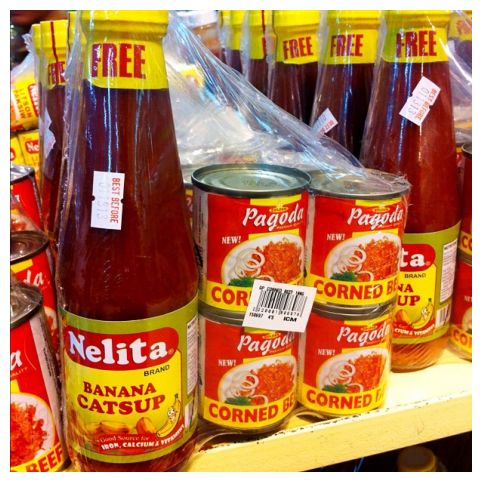

Pregunta: what is the brand on the bottle?
Respuestas posibles: ['nelita', 'nelita', 'nelita', 'nelita', 'nelita', 'nelita', 'nelita', 'nelita', 'nelita', 'nelita']
Respuesta final más probable: nelita

Usando OCR y GPT-2:
No se pudo extraer texto de la imagen.

Usando Donut:


sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/803M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.donut.modeling_donut_swin.DonutSwinModel'> is overwritten by shared encoder config: DonutSwinConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    14,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": [
    2560,
    1920
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "donut-swin",
  "num_channels": 3,
  "num_heads": [
    4,
    8,
    16,
    32
  ],
  "num_layers": 4,
  "patch_size": 4,
  "path_norm": true,
  "qkv_bias": true,
  "transformers_version": "4.46.2",
  "use_absolute_embeddings": false,
  "window_size": 10
}

Config of the decoder: <class 'transformers.models.mbart.modeling_mbart.MBartForCausalLM'> is overwritten by shared decoder config: MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "add

model.safetensors:   0%|          | 0.00/803M [00:00<?, ?B/s]

Respuesta generada por Donut: what is the brand on the bottle? na


In [ ]:
### Obtenemos descripciones con OCR y donut

import os
import json
import random
import requests
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from io import BytesIO
import pytesseract
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, DonutProcessor, VisionEncoderDecoderModel

# Extraer texto de la imagen usando OCR
def extraer_texto(img):
    return pytesseract.image_to_string(img)

# Generar respuesta usando GPT-2
def generar_respuesta_con_gpt2(pregunta, contexto):
    from transformers import GPT2Tokenizer, GPT2LMHeadModel

    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    model = GPT2LMHeadModel.from_pretrained('gpt2')

    # Codificar la entrada
    entrada = f"Contexto: {contexto}\nPregunta: {pregunta}\nRespuesta:"
    inputs = tokenizer.encode(entrada, return_tensors='pt')

    # Ajustar max_new_tokens en lugar de max_length
    outputs = model.generate(
        inputs,
        max_new_tokens=50,  # Genera hasta 50 tokens adicionales
        pad_token_id=tokenizer.eos_token_id,
        num_return_sequences=1
    )

    respuesta = tokenizer.decode(outputs[0], skip_special_tokens=True)
    respuesta = respuesta.split("Respuesta:")[-1].strip()
    return respuesta


# Predecir respuesta usando OCR y GPT-2
def predecir_respuesta_con_ocr(ejemplo, img):
    if not img:
        print("Imagen no disponible para OCR.")
        return
    texto = extraer_texto(img)
    if not texto.strip():
        print("No se pudo extraer texto de la imagen.")
        return
    respuesta = generar_respuesta_con_gpt2(ejemplo['question'], texto)
    print(f"Respuesta generada con OCR y GPT-2: {respuesta}")

# Predecir respuesta usando Donut
def predecir_respuesta_con_donut(ejemplo, img):
    if not img:
        print("Imagen no disponible para Donut.")
        return

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")
    model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa").to(device)

    pixel_values = processor(img, return_tensors="pt").pixel_values.to(device)
    prompt = f"<s_docvqa><s_question>{ejemplo['question']}</s_question><s_answer>"
    input_ids = processor.tokenizer(prompt, add_special_tokens=False, return_tensors="pt").input_ids.to(device)

    outputs = model.generate(pixel_values, decoder_input_ids=input_ids, max_length=256)
    respuesta = processor.batch_decode(outputs, skip_special_tokens=True)[0].replace('<s_docvqa>', '').strip()
    print(f"Respuesta generada por Donut: {respuesta}")

# Flujo principal
def ejecutar_ejemplo():
    dataset = cargar_dataset(ruta_json)
    ejemplo, img, image_path = obtener_ejemplo_aleatorio(dataset, ruta_imagenes)
    mostrar_ejemplo(ejemplo, img)

    print("\nUsando OCR y GPT-2:")
    predecir_respuesta_con_ocr(ejemplo, img)

    print("\nUsando Donut:")
    predecir_respuesta_con_donut(ejemplo, img)

if __name__ == "__main__":
    ejecutar_ejemplo()


# 4) Modelos de generación de texto

### Hiperparámetros Comunes en la Generación de Texto


### **1. Longitud Máxima (max_length)**
- **¿Qué es?**: Especifica cuántos tokens puede tener como máximo el texto generado, incluyendo los tokens iniciales.
- **Impacto**: Limita la extensión del texto. Si se alcanza este valor, el modelo detendrá la generación.
- **Útil para**: Evitar respuestas demasiado largas o cortar texto innecesario.



### **2. Muestreo Aleatorio (do_sample)**
- **¿Qué es?**: Permite introducir aleatoriedad en la generación de texto, en lugar de elegir siempre el token más probable.
- **Impacto**: Hace que las respuestas sean más diversas y creativas.
- **Útil para**: Escenarios donde la variedad es importante, como la escritura creativa.



### **3. Número de Opciones Más Probables (top_k)**
- **¿Qué es?**: Limita la elección del siguiente token a los `k` tokens más probables.
- **Impacto**: Reduce la probabilidad de generar texto incoherente, pero mantiene cierta diversidad.
- **Útil para**: Balancear entre coherencia y creatividad.


### **4. Control de Creatividad (temperature)**
- **¿Qué es?**: Ajusta la aleatoriedad en la selección de tokens. Valores más bajos generan texto más conservador, mientras que valores más altos promueven la creatividad.
- **Impacto**:
  - **Baja temperatura (e.g., 0.2)**: Texto más predecible y seguro.
  - **Alta temperatura (e.g., 1.0)**: Texto más variado y creativo.
- **Útil para**: Ajustar el tono y estilo del texto según el contexto.


### **5. Token de Relleno (pad_token_id)**
- **¿Qué es?**: Un token especial utilizado para alinear secuencias de diferentes longitudes en un lote (*batch*).
- **Impacto**: No afecta directamente al texto generado, pero es crucial para que el modelo procese correctamente los datos en lotes.
- **Útil para**: Procesamiento eficiente de múltiples secuencias en paralelo.


### **Hiperparámetros adicionales**

#### **Número de Caminos Simultáneos (num_beams)**
- **¿Qué es?**: Indica cuántas alternativas simultáneas considera el modelo durante la generación de texto.
- **Impacto**: Mejora la calidad del texto a costa de mayor tiempo de procesamiento.
- **Útil para**: Escenarios donde la calidad es más importante que la rapidez.

#### **Detención Temprana (early_stopping)**
- **¿Qué es?**: Finaliza la generación de texto cuando se alcanza un token específico de finalización.
- **Impacto**: Evita que el modelo genere texto más allá de lo necesario.
- **Útil para**: Respuestas precisas y controladas.

#### **Penalización por Repetición (repetition_penalty)**
- **¿Qué es?**: Penaliza la repetición de palabras o frases para evitar redundancias.
- **Impacto**: Mejora la fluidez del texto.
- **Útil para**: Textos más variados y naturales.


In [ ]:
#@title Ejemplo generamos texto con una pregunta y repuesta

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Cargar el modelo y el tokenizador
modelo_es = "EleutherAI/gpt-neo-1.3B"  # Modelo autoregresivo para generación de texto
tokenizer_es = AutoTokenizer.from_pretrained(modelo_es)
modelo_generador_es = AutoModelForCausalLM.from_pretrained(modelo_es).to("cuda" if torch.cuda.is_available() else "cpu")

def generar_descripcion_larga(pregunta, respuesta):
    """
    Genera una descripción larga en español basada en la pregunta y la respuesta proporcionadas.
    """
    # Crear el prompt en español
    prompt = (f"Basado en la pregunta '{pregunta}' y la respuesta '{respuesta}', "
              f"genera una descripción detallada del contexto relacionado con la imagen:")

    # Tokenizar el prompt
    inputs = tokenizer_es(prompt, return_tensors="pt").to(modelo_generador_es.device)

    # Generar el texto
    outputs = modelo_generador_es.generate(
        inputs.input_ids,
        max_length=300,  # Longitud máxima
        do_sample=True,
        top_k=50,
        temperature=0.7,
        pad_token_id=tokenizer_es.eos_token_id
    )

    # Decodificar el texto generado
    descripcion_generada = tokenizer_es.decode(outputs[0], skip_special_tokens=True)
    return descripcion_generada

# Ejemplo de uso
pregunta_es = "¿Qué producto se anuncia en la cartelera?"
respuesta_es = "Coca Cola"

descripcion = generar_descripcion_larga(pregunta_es, respuesta_es)
print("\nDescripción generada:\n", descripcion)


tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]


Descripción generada:
 Basado en la pregunta '¿Qué producto se anuncia en la cartelera?' y la respuesta 'Coca Cola', genera una descripción detallada del contexto relacionado con la imagen:

La carta que el presidente de la República puso a la venta en el año 2000 presenta una imagen de su propio país, que ha ido desapareciendo en la historia. La carta está inspirada en el país de César Chávez, quien, en su forma de vida había perdido la vida a los seres humanos, y estaba destinado a la venta en el año 2000:

"Estoy muy preocupado por lo que pueda pasarle a la gente de Cuba en el futuro. El país se ha transformado en una nación desconocida, sin idea de la libertad de expresión y de acción, la impunidad y la violencia, y el país perdió la capacidad de expresión de la humanidad.

El país se ha convertido en una nación que no sabía qué hacer y está intentando hacer algo.


In [ ]:
### TODO 3: Usar el dataset "TextVQA", extraer 10 registros
### Usando la pregunta y repuesta, de los registros extraido, creae un nuevo texto con el modelo_es = "EleutherAI/gpt-neo-1.3B"

In [ ]:
#@title solución

import json
import random
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Configuración del modelo para generación de texto
modelo_es = "EleutherAI/gpt-neo-1.3B"
tokenizer_es = AutoTokenizer.from_pretrained(modelo_es)
modelo_generador_es = AutoModelForCausalLM.from_pretrained(modelo_es).to("cuda" if torch.cuda.is_available() else "cpu")

# Función para generar descripción detallada
def generar_descripcion_larga(pregunta, respuesta):
    """
    Genera una descripción larga en español basada en la pregunta y la respuesta proporcionadas.
    """
    prompt = (f"Basado en la pregunta '{pregunta}' y la respuesta '{respuesta}', "
              f"genera una descripción detallada del contexto relacionado con la imagen:")
    inputs = tokenizer_es(prompt, return_tensors="pt").to(modelo_generador_es.device)
    outputs = modelo_generador_es.generate(
        inputs.input_ids,
        max_length=300,
        do_sample=True,
        top_k=50,
        temperature=0.7,
        pad_token_id=tokenizer_es.eos_token_id
    )
    descripcion_generada = tokenizer_es.decode(outputs[0], skip_special_tokens=True)
    return descripcion_generada

# Cargar dataset TextVQA
def cargar_dataset(ruta_json):
    """
    Carga el dataset TextVQA desde un archivo JSON.
    """
    with open(ruta_json, "r") as f:
        dataset = json.load(f)

    # Inspeccionar la estructura del dataset
    if isinstance(dataset, dict):
        print("Dataset es un diccionario. Claves:", dataset.keys())
        # Ajustar para acceder a los registros si están en una clave específica
        dataset = dataset.get("data", dataset.get("annotations", []))
    elif isinstance(dataset, list):
        print("Dataset es una lista con", len(dataset), "registros.")
    else:
        raise TypeError("El dataset no tiene un formato compatible.")

    return dataset

# Extraer 10 registros del dataset
def extraer_registros(dataset, n=10):
    """
    Extrae n registros del dataset. El dataset debe ser una lista de diccionarios.
    """
    if not isinstance(dataset, list):
        raise TypeError("El dataset no es una lista. Verifica la estructura del JSON.")
    return random.sample(dataset, n)

# Procesar los registros
def procesar_registros(registros):
    """
    Genera descripciones para los registros extraídos.
    """
    descripciones = []
    for registro in registros:
        pregunta = registro.get('question', "Sin pregunta")
        respuestas = registro.get('answers', ["Sin respuesta"])
        respuesta = respuestas[0] if respuestas else "Sin respuesta"
        descripcion = generar_descripcion_larga(pregunta, respuesta)
        descripciones.append({
            "pregunta": pregunta,
            "respuesta": respuesta,
            "descripcion": descripcion
        })
    return descripciones

# Flujo principal
def main():
    ruta_dataset = "TextVQA_0.5.1_train.json"  # Cambiar por la ruta real al archivo TextVQA
    dataset = cargar_dataset(ruta_dataset)

    if not dataset or not isinstance(dataset, list):
        print("El dataset está vacío o no tiene la estructura esperada.")
        return

    registros = extraer_registros(dataset, n=10)
    descripciones = procesar_registros(registros)

    # Mostrar los resultados
    for idx, descripcion in enumerate(descripciones):
        print(f"\nRegistro {idx+1}:")
        print(f"Pregunta: {descripcion['pregunta']}")
        print(f"Respuesta: {descripcion['respuesta']}")
        print(f"Descripción Generada: {descripcion['descripcion']}")

if __name__ == "__main__":
    main()


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Dataset es un diccionario. Claves: dict_keys(['dataset_type', 'dataset_name', 'dataset_version', 'data'])

Registro 1:
Pregunta: what is the model number of this van series?
Respuesta: 2500
Descripción Generada: Basado en la pregunta 'what is the model number of this van series?' y la respuesta '2500', genera una descripción detallada del contexto relacionado con la imagen:

"The van is a commercial vehicle that is used by some hotels and restaurants for food delivery. The van is owned by a local company, called Van Service Company, which is a subsidiary of the company that owns the van.

The van is rented to the hotel, and then the van is used by the restaurant to deliver the food. The van is delivered to the customer's location, and is picked up by the restaurant.

The van is usually driven by a person who is not the restaurant's employee. The van is driven by a person who is not a food delivery person.

The van is driven by a person who is not the restaurant's employee. The van is d

In [ ]:
### Opcional: cambia el codigo anterior y utiliza alguno de los siguientes modelos
#modelo_es = "datificate/gpt2-small-spanish"  # GPT-2 ajustado al español
#modelo_es = "LenguajeNaturalAI/leniachat-gemma-2b-v0"  # Chatbot avanzado en español
#modelo_es = "QuantFactory/leniachat-gemma-2b-v0-GGUF"  # Optimizado para chat en español
#modelo_es = "Nichonauta/pepita-2-2b-it-v1-Q4_0-GGUF"  # Optimizado para hardware con recursos limitados
#modelo_es = "PlanTL-GOB-ES/roberta-base-bne"  # Entrenado en el corpus BNE español
#modelo_es = "mrm8488/spanish-gpt2"  # GPT-2 ajustado en español
#modelo_es = "HuggingFace/CodeParrot"  # Generador de código adaptable a español

### ¿Los modelos estan disponibles? ¿Que modelo le parece el más eficiente?

### Creamos un sample del dataset original

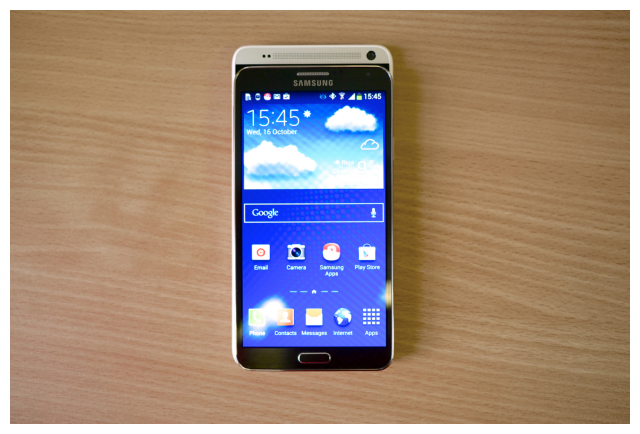

Pregunta: what is the date on this phone?
Respuestas posibles: ['16 october', '16 october', '16 october', 'google', 'october 16', 'wed. 16 october', 'no', '10/16', 'october 16', 'wed 16 october']
Respuesta final más probable: 16 october


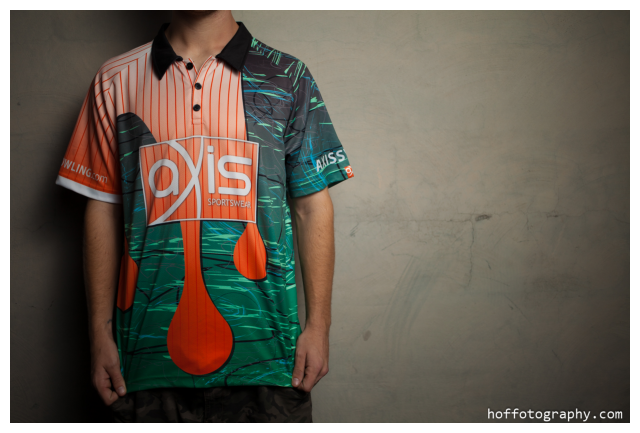

Pregunta: is he wearing something related to sports?
Respuestas posibles: ['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes']
Respuesta final más probable: yes


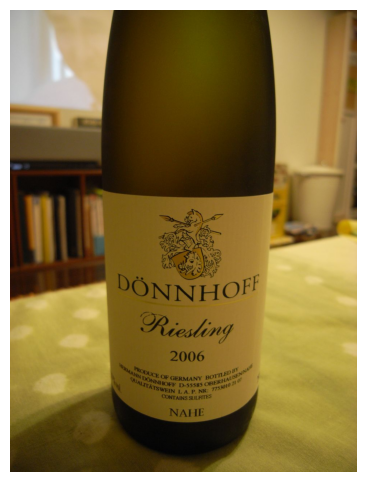

Pregunta: what year is this bottle from?
Respuestas posibles: ['2006', '2006', '30', '2006', '2006', '2006', '2006', '2006', '2006', '2006']
Respuesta final más probable: 2006


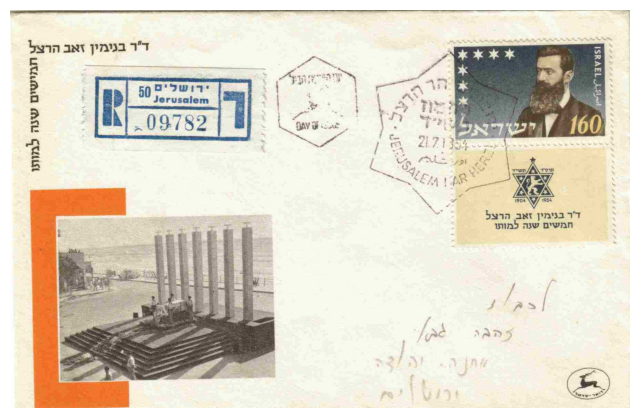

Pregunta: 160 postage stamp?
Respuestas posibles: ['yes', 'yes', 'not a question', 'yes', 'yes', 'yes', 'yes', 'not a question', 'not a question', 'ye']
Respuesta final más probable: yes


In [ ]:
import os
import json
from PIL import Image
import random
import matplotlib.pyplot as plt

def descargar_imagenes_y_crear_dataset(num_imagenes=4, ruta_dataset="dataset_vqa", cargar_funciones=None):
    """
    Crea un dataset utilizando funciones externas para cargar imágenes y generar preguntas y respuestas.
    """
    if not cargar_funciones:
        raise ValueError("Se deben proporcionar las funciones cargar_dataset, obtener_ejemplo_aleatorio y mostrar_ejemplo.")

    cargar_dataset, obtener_ejemplo_aleatorio, mostrar_ejemplo = cargar_funciones

    dataset = []
    #ruta_json = os.path.join(ruta_dataset, "dataset.json")

    if not os.path.exists(ruta_dataset):
        os.makedirs(ruta_dataset)

    for i in range(num_imagenes):
        ejemplo, img, image_path = obtener_ejemplo_aleatorio(cargar_dataset(ruta_json), ruta_dataset)
        pregunta, respuesta = mostrar_ejemplo(ejemplo, img)

        dataset.append({
            "image_path": image_path,
            "question": pregunta,
            "answer": respuesta
        })

    # Guardar el dataset en formato JSON
    with open(ruta_json, "w") as json_file:
        json.dump({"data": dataset}, json_file, indent=4)

    return dataset

# Ejecución
ruta_dataset = "dataset_vqa_en"
funciones_cargar = (cargar_dataset, obtener_ejemplo_aleatorio, mostrar_ejemplo)

dataset_en = descargar_imagenes_y_crear_dataset(
    num_imagenes=4,
    ruta_dataset=ruta_dataset,
    cargar_funciones=funciones_cargar
)


In [ ]:
print(dataset_en)

[{'image_path': 'dataset_vqa_en/120b3cbd2dcff6eb.jpg', 'question': 'what is the date on this phone?', 'answer': '16 october'}, {'image_path': 'dataset_vqa_en/7035f9ed3ac7f0d5.jpg', 'question': 'is he wearing something related to sports?', 'answer': 'yes'}, {'image_path': 'dataset_vqa_en/24495eadde5b3810.jpg', 'question': 'what year is this bottle from?', 'answer': '2006'}, {'image_path': 'dataset_vqa_en/0ea34c96d1440d6e.jpg', 'question': '160 postage stamp?', 'answer': 'yes'}]


In [ ]:
### TODO 4: Crea un dataset "dataset_vqa_es"
# Traduce cada pregunta y repuesta al español usando ("translation_en_to_es", model="Helsinki-NLP/opus-mt-en-es")
# Carga al menos 30 registros
# puede usar descargar_imagenes_y_crear_dataset(num_imagenes=4, ruta_dataset="dataset_vqa", cargar_funciones=None) u otra funcion que cocnsidera adecuada


In [ ]:
#@title solución

import os
import json
from transformers import pipeline
from PIL import Image
import random

# Paso 1: Configurar el pipeline de traducción de inglés a español
traductor = pipeline("translation_en_to_es", model="Helsinki-NLP/opus-mt-en-es")

def traducir_pregunta_y_respuesta(pregunta, respuesta):
    """
    Traduce una pregunta y una respuesta del inglés al español.
    """
    pregunta_es = traductor(pregunta)[0]['translation_text']
    respuesta_es = traductor(respuesta)[0]['translation_text']
    return pregunta_es, respuesta_es

def descargar_y_crear_dataset_vqa_es(num_imagenes=30, ruta_dataset="dataset_vqa_es", cargar_funciones=None):
    """
    Crea un dataset traducido al español utilizando funciones externas para cargar imágenes y preguntas/respuestas.
    """
    if not cargar_funciones:
        raise ValueError("Se deben proporcionar las funciones cargar_dataset, obtener_ejemplo_aleatorio y mostrar_ejemplo.")

    cargar_dataset, obtener_ejemplo_aleatorio, mostrar_ejemplo = cargar_funciones

    dataset = []
    ruta_json = os.path.join(ruta_dataset, "dataset_es.json")

    if not os.path.exists(ruta_dataset):
        os.makedirs(ruta_dataset)

    for i in range(num_imagenes):
        ejemplo, img, image_path = obtener_ejemplo_aleatorio(cargar_dataset(ruta_json), ruta_dataset)
        pregunta_en, respuesta_en = mostrar_ejemplo(ejemplo, img)

        # Traducir pregunta y respuesta
        pregunta_es, respuesta_es = traducir_pregunta_y_respuesta(pregunta_en, respuesta_en)

        dataset.append({
            "image_path": image_path,
            "question": pregunta_es,
            "answer": respuesta_es
        })

    # Guardar el dataset traducido en formato JSON
    with open(ruta_json, "w") as json_file:
        json.dump({"data": dataset}, json_file, indent=4)

    return dataset

# Ejecución
ruta_dataset = "dataset_vqa_es"
funciones_cargar = (cargar_dataset, obtener_ejemplo_aleatorio, mostrar_ejemplo)

dataset_es = descargar_y_crear_dataset_vqa_es(
    num_imagenes=30,
    ruta_dataset=ruta_dataset,
    cargar_funciones=funciones_cargar
)


# 5) Fine-tuning del modelo BLIP para Visual Question Answering

En este proyecto realizaremos un **fine-tuning** del modelo **BLIP (Bootstrapped Language-Image Pre-training)**, específicamente para la tarea de **Visual Question Answering (VQA)**. Esto implica entrenar el modelo en un conjunto personalizado de datos, donde cada muestra consta de una imagen, una pregunta sobre esa imagen, y una respuesta asociada.

### Pasos principales:

1. **Creación del Dataset**:
   Se utilizan imágenes aleatorias junto con preguntas y respuestas generadas manualmente. Este dataset personalizado servirá para entrenar y validar el modelo.

2. **Carga del Modelo BLIP**:
   BLIP combina información visual (de las imágenes) y textual (de las preguntas) para generar respuestas. Utilizaremos su capacidad para aprender a responder preguntas específicas basadas en nuestro dataset.

3. **Entrenamiento y Validación**:
   El modelo se entrena en las imágenes y preguntas del dataset, ajustando sus parámetros para minimizar el error en las respuestas generadas. Luego, se valida su desempeño en un conjunto separado de datos.

4. **Evaluación**:
   Después del entrenamiento, se evalúa el modelo con ejemplos nuevos, observando cómo genera respuestas basadas en imágenes nunca vistas durante el entrenamiento.

### Beneficios de este proceso:

- **Adaptación a tareas específicas**: El modelo aprende a resolver problemas específicos, como responder preguntas particulares sobre un tipo de imágenes.
- **Eficiencia**: Al partir de un modelo preentrenado, se requiere menos tiempo y datos para lograr buenos resultados.
- **Aplicaciones personalizadas**: Este enfoque puede aplicarse en áreas como medicina, educación y automatización de procesos documentales.


Epoch 1/3
Train Loss: 11.1483, Validation Loss: 10.3091
Epoch 2/3
Train Loss: 10.3076, Validation Loss: 10.2908
Epoch 3/3
Train Loss: 10.2941, Validation Loss: 10.2811
Pregunta: is the object round?
Respuesta esperada: yes
Respuesta generada: yes


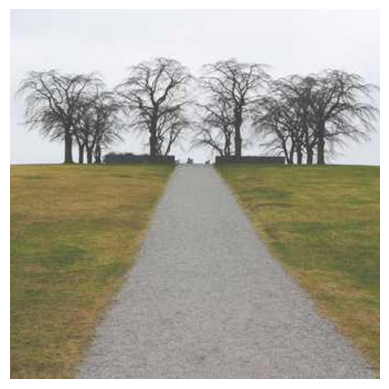

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BlipProcessor, BlipForQuestionAnswering
from PIL import Image
import random
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import os

# Definir el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crear una carpeta para guardar las imágenes si no existe
os.makedirs('dataset_vqa_test', exist_ok=True)

# Descargar 4 imágenes aleatorias de picsum.photos y guardarlas
for i in range(4):
    response = requests.get(f"https://picsum.photos/500/500?random={i}")
    with open(f"dataset_vqa_test/image_{i}.jpg", 'wb') as f:
        f.write(response.content)

# Crearmos un dataset hardcodeado con preguntas y respuestas al azar
dataset_personalizado = [
    {'image_path': 'dataset_vqa_test/image_0.jpg', 'question': 'what is the color of the sky?', 'answer': 'blue'},
    {'image_path': 'dataset_vqa_test/image_1.jpg', 'question': 'how many people are there?', 'answer': 'three'},
    {'image_path': 'dataset_vqa_test/image_2.jpg', 'question': 'what is the object in the center?', 'answer': 'tree'},
    {'image_path': 'dataset_vqa_test/image_3.jpg', 'question': 'is the object round?', 'answer': 'yes'}
]

# Clase de Dataset personalizado
class VQADataset(Dataset):
    """
    Dataset personalizado para Visual Question Answering.
    """
    def __init__(self, data, processor):
        self.data = data
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = Image.open(item['image_path']).convert('RGB')
        # Procesar imagen y pregunta
        encoding = self.processor(images=image, text=item['question'], padding='max_length', truncation=True, return_tensors="pt")
        # Tokenizar la respuesta para obtener las etiquetas
        labels = self.processor.tokenizer(item['answer'], padding='max_length', truncation=True, return_tensors="pt").input_ids
        # Asegurarse de que los tensores tengan la dimensión correcta
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        labels = labels.squeeze()
        encoding['labels'] = labels
        #print(encoding['attention_mask'])  # Verifica que se genere correctamente
        #print(inputs['attention_mask'].shape)  # Verificar que la máscara se esté usando
        return encoding

# Asegurarse de que hay suficientes datos para entrenamiento y validación
if len(dataset_personalizado) < 2:
    print("Necesitas al menos 2 datos para dividir en entrenamiento y validación.")
else:
    # Dividir dataset en entrenamiento y validación
    random.shuffle(dataset_personalizado)
    division = int(0.8 * len(dataset_personalizado))
    train_data = dataset_personalizado[:division]
    val_data = dataset_personalizado[division:]

    # Cargar modelo y procesador BLIP
    processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
    model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to(device)

    # Crear DataLoaders
    train_dataset = VQADataset(train_data, processor)
    val_dataset = VQADataset(val_data, processor)
    train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=2)

    # Configuración del optimizador y entrenamiento
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

    def train_epoch(model, dataloader, optimizer):
        """
        Entrena el modelo por una época.
        """
        model.train()
        total_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def eval_epoch(model, dataloader):
        """
        Evalúa el modelo en el dataset de validación.
        """
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch in dataloader:
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)
                outputs = model(**inputs, labels=labels)
                total_loss += outputs.loss.item()
        return total_loss / len(dataloader)

    # Entrenar el modelo
    num_epochs = 3
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_loss = train_epoch(model, train_dataloader, optimizer)
        val_loss = eval_epoch(model, val_dataloader)
        print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Guardar el modelo ajustado
    model.save_pretrained("blip-vqa-finetuned")
    processor.save_pretrained("blip-vqa-finetuned")

    # Probar el modelo ajustado
    def generar_respuesta(model, processor, image_path, question):
        """
        Genera una respuesta a partir de una imagen y una pregunta.
        """
        image = Image.open(image_path).convert('RGB')
        inputs = processor(images=image, text=question, return_tensors="pt").to(device)
        # Generar respuesta
        outputs = model.generate(**inputs)
        respuesta = processor.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return respuesta

    # Ejemplo de prueba
    ejemplo = val_data[0]
    print(f"Pregunta: {ejemplo['question']}")
    print(f"Respuesta esperada: {ejemplo['answer']}")
    print(f"Respuesta generada: {generar_respuesta(model, processor, ejemplo['image_path'], ejemplo['question'])}")
    plt.imshow(Image.open(ejemplo['image_path']))
    plt.axis('off')
    plt.show()


In [ ]:
### TODO 5: Tomando como base el modelo de la anterior celda
# Reemplazar el dataset personalizado por "dataset_vqa_es" con preguntas y respuestas en español.
# Realizar Fine-tuning del modelo BLIP
# Modificar hiperparámetros como lr, batch_size, num_epochs y otros que considere necesario, para optimizar el modelo.

# ¿Qué desafíos podrían surgir al aplicar este modelo en un entorno real con imágenes complejas?

#Complementario
# Aplicar data augmentation al dataset para mejorar la generalización del modelo.
# Crear una interfaz interactiva para probar el modelo con nuevas imágenes y preguntas.

In [ ]:
#@title solución - parte a

import os
import json
import random
from transformers import MarianMTModel, MarianTokenizer
from PIL import Image
import requests
from io import BytesIO
import time

# Definir las rutas
ruta_json_en = "TextVQA_0.5.1_train.json"  # Archivo JSON con el dataset en inglés
ruta_dataset_es = "dataset_vqa_es"         # Carpeta donde guardaremos el dataset en español
ruta_imagenes = os.path.join(ruta_dataset_es, "images")  # Carpeta para las imágenes

# Crear las carpetas si no existen
os.makedirs(ruta_dataset_es, exist_ok=True)
os.makedirs(ruta_imagenes, exist_ok=True)

# Paso 1: Cargar el dataset en inglés
with open(ruta_json_en, "r", encoding='utf-8') as json_file:
    dataset_json = json.load(json_file)

# Inspeccionar la estructura del dataset
if isinstance(dataset_json, dict):
    print("El dataset es un diccionario. Claves:", dataset_json.keys())
    dataset_en = dataset_json.get("data", [])
elif isinstance(dataset_json, list):
    print("El dataset es una lista con", len(dataset_json), "registros.")
    dataset_en = dataset_json
else:
    raise TypeError("El dataset no tiene un formato compatible.")

# Paso 2: Configurar el traductor
modelo_traduccion = "Helsinki-NLP/opus-mt-en-es"
tokenizer_traductor = MarianTokenizer.from_pretrained(modelo_traduccion)
model_traductor = MarianMTModel.from_pretrained(modelo_traduccion)

def traducir_texto(texto):
    translated = model_traductor.generate(**tokenizer_traductor(texto, return_tensors="pt", padding=True))
    texto_traducido = tokenizer_traductor.decode(translated[0], skip_special_tokens=True)
    return texto_traducido

# Paso 3: Seleccionar registros aleatorios y procesarlos
dataset_es = []
registros_procesados = 0
registros_deseados = 30
max_intentos = 500  # Máximo de intentos para evitar bucles infinitos
contador_intentos = 0

print("Procesando registros para crear el dataset en español...")

while registros_procesados < registros_deseados and contador_intentos < max_intentos:
    contador_intentos += 1
    # Seleccionar un registro aleatorio
    item = random.choice(dataset_en)

    pregunta_en = item.get("question", "")
    respuestas_en = item.get("answers", [])
    image_id = item.get("image_id", "")
    image_url = item.get("flickr_original_url", "")  # Usar 'flickr_original_url' para descargar la imagen

    # Verificar que tenemos los datos necesarios
    if not pregunta_en or not respuestas_en or not image_id or not image_url:
        continue  # Saltar si falta información esencial

    # Tomar la respuesta más frecuente
    respuesta_en = max(set(respuestas_en), key=respuestas_en.count)

    # Construir la ruta de la imagen
    image_filename = f"{image_id}.jpg"
    image_path = os.path.join(ruta_imagenes, image_filename)

    # Verificar si la imagen ya fue procesada para evitar duplicados
    if any(d['image_path'] == image_path for d in dataset_es):
        continue  # Ya procesamos este registro, pasamos al siguiente

    # Verificar si la imagen existe, si no, intentar descargarla
    if not os.path.exists(image_path):
        try:
            response = requests.get(image_url, timeout=10)
            if response.status_code == 200:
                img = Image.open(BytesIO(response.content)).convert('RGB')
                img.save(image_path)
            else:
                # No se pudo descargar la imagen
                continue
        except Exception:
            # Error al descargar la imagen
            continue

    # Traducir la pregunta y la respuesta
    try:
        pregunta_es = traducir_texto(pregunta_en)
        respuesta_es = traducir_texto(respuesta_en)
    except Exception as e:
        print(f"Error al traducir: {e}")
        continue

    # Añadir al dataset en español
    item_es = {
        "image_path": image_path,
        "question": pregunta_es,
        "answer": respuesta_es
    }
    dataset_es.append(item_es)
    registros_procesados += 1
    print(f"Registros procesados: {registros_procesados}/{registros_deseados}")

print(f"Dataset en español creado con {len(dataset_es)} registros.")
print(f"Total de intentos realizados: {contador_intentos}")

# Paso 4: Guardar el dataset en español
ruta_json_es = os.path.join(ruta_dataset_es, "dataset_es.json")
with open(ruta_json_es, "w", encoding='utf-8') as json_file:
    json.dump({"data": dataset_es}, json_file, indent=4, ensure_ascii=False)


El dataset es un diccionario. Claves: dict_keys(['dataset_type', 'dataset_name', 'dataset_version', 'data'])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Procesando registros para crear el dataset en español...
Registros procesados: 1/30
Registros procesados: 2/30
Registros procesados: 3/30
Registros procesados: 4/30
Registros procesados: 5/30
Registros procesados: 6/30
Registros procesados: 7/30
Registros procesados: 8/30
Registros procesados: 9/30
Registros procesados: 10/30
Registros procesados: 11/30
Registros procesados: 12/30
Registros procesados: 13/30
Registros procesados: 14/30
Registros procesados: 15/30
Registros procesados: 16/30
Registros procesados: 17/30
Registros procesados: 18/30
Registros procesados: 19/30
Registros procesados: 20/30
Registros procesados: 21/30
Registros procesados: 22/30
Registros procesados: 23/30
Registros procesados: 24/30
Registros procesados: 25/30
Registros procesados: 26/30
Registros procesados: 27/30
Registros procesados: 28/30
Registros procesados: 29/30
Registros procesados: 30/30
Dataset en español creado con 30 registros.
Total de intentos realizados: 40


Usando el dispositivo: cuda


tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Epoch 1/10


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Train Loss: 10.7410, Validation Loss: 10.3717
Epoch 2/10
Train Loss: 10.3350, Validation Loss: 10.3171
Epoch 3/10
Train Loss: 10.3002, Validation Loss: 10.3004
Epoch 4/10
Train Loss: 10.2873, Validation Loss: 10.2917
Epoch 5/10
Train Loss: 10.2787, Validation Loss: 10.2852
Epoch 6/10
Train Loss: 10.2714, Validation Loss: 10.2796
Epoch 7/10
Train Loss: 10.2645, Validation Loss: 10.2745
Epoch 8/10
Train Loss: 10.2580, Validation Loss: 10.2696
Epoch 9/10
Train Loss: 10.2519, Validation Loss: 10.2647
Epoch 10/10
Train Loss: 10.2457, Validation Loss: 10.2600


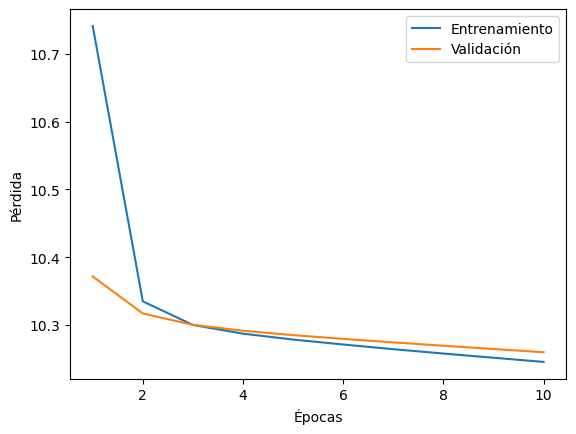

Pregunta: ¿Qué número hay en su camiseta?
Respuesta esperada: 33
Respuesta generada: 34


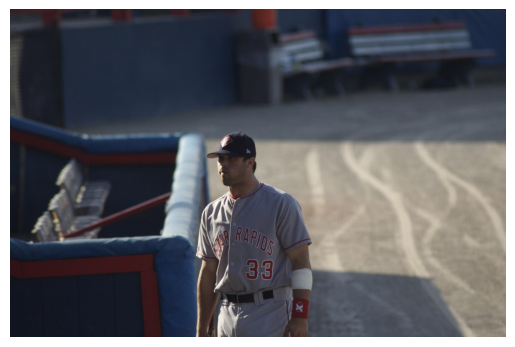

In [ ]:
#@title solución - parte b

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BlipProcessor, BlipForQuestionAnswering
from PIL import Image
import random
import matplotlib.pyplot as plt
import os
import json

# Definir el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando el dispositivo: {device}")

# Cargar el dataset en español
ruta_dataset_es = "dataset_vqa_es"
ruta_json_es = os.path.join(ruta_dataset_es, "dataset_es.json")

# Verificar si el dataset existe
if not os.path.exists(ruta_json_es):
    print("El dataset en español no existe. Por favor, ejecuta el código para traducir el dataset.")
else:
    with open(ruta_json_es, "r", encoding='utf-8') as json_file:
        dataset_es = json.load(json_file)["data"]

    # Ajustar los paths de las imágenes si es necesario
    for item in dataset_es:
        # Si las imágenes están en 'dataset_vqa_en', actualiza el 'image_path'
        image_path = item["image_path"]
        if not os.path.exists(image_path):
            # Actualizar el path al correcto
            nombre_imagen = os.path.basename(image_path)
            item["image_path"] = os.path.join("dataset_vqa_en", nombre_imagen)

    # Mezclar los datos
    random.shuffle(dataset_es)

    # Dividir dataset en entrenamiento y validación (80% entrenamiento, 20% validación)
    division = int(0.8 * len(dataset_es))
    train_data = dataset_es[:division]
    val_data = dataset_es[division:]

    # Cargar modelo y procesador BLIP
    processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
    model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to(device)

    # Clase de Dataset personalizado
    class VQADataset(Dataset):
        """
        Dataset personalizado para Visual Question Answering.
        """
        def __init__(self, data, processor):
            self.data = data
            self.processor = processor

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            item = self.data[idx]
            image = Image.open(item['image_path']).convert('RGB')
            # Procesar imagen y pregunta
            encoding = self.processor(images=image, text=item['question'], padding='max_length', truncation=True, return_tensors="pt")
            # Tokenizar la respuesta para obtener las etiquetas
            labels = self.processor.tokenizer(text=item['answer'], padding='max_length', truncation=True, return_tensors="pt").input_ids
            # Asegurarse de que los tensores tengan la dimensión correcta
            encoding = {k: v.squeeze() for k, v in encoding.items()}
            labels = labels.squeeze()
            encoding['labels'] = labels
            return encoding

    # Crear DataLoaders con batch_size ajustado
    batch_size = 4  # Puedes ajustar este valor según tu GPU
    train_dataset = VQADataset(train_data, processor)
    val_dataset = VQADataset(val_data, processor)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    # Configuración del optimizador y entrenamiento
    lr = 5e-6  # Learning rate ajustado
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    def train_epoch(model, dataloader, optimizer):
        """
        Entrena el modelo por una época.
        """
        model.train()
        total_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def eval_epoch(model, dataloader):
        """
        Evalúa el modelo en el dataset de validación.
        """
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch in dataloader:
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)
                outputs = model(**inputs, labels=labels)
                total_loss += outputs.loss.item()
        return total_loss / len(dataloader)

    # Entrenar el modelo
    num_epochs = 10  # Ajustar el número de épocas
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_loss = train_epoch(model, train_dataloader, optimizer)
        val_loss = eval_epoch(model, val_dataloader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Guardar el modelo ajustado
    model.save_pretrained("blip-vqa-finetuned-es")
    processor.save_pretrained("blip-vqa-finetuned-es")

    # Graficar las pérdidas
    plt.plot(range(1, num_epochs+1), train_losses, label='Entrenamiento')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()

    # Probar el modelo ajustado
    def generar_respuesta(model, processor, image_path, question):
        """
        Genera una respuesta a partir de una imagen y una pregunta.
        """
        image = Image.open(image_path).convert('RGB')
        inputs = processor(images=image, text=question, return_tensors="pt").to(device)
        # Generar respuesta
        outputs = model.generate(**inputs, max_length=20)
        respuesta = processor.decode(outputs[0], skip_special_tokens=True)
        return respuesta

    # Ejemplo de prueba
    ejemplo = val_data[0]
    print(f"Pregunta: {ejemplo['question']}")
    print(f"Respuesta esperada: {ejemplo['answer']}")
    respuesta_generada = generar_respuesta(model, processor, ejemplo['image_path'], ejemplo['question'])
    print(f"Respuesta generada: {respuesta_generada}")
    plt.imshow(Image.open(ejemplo['image_path']))
    plt.axis('off')
    plt.show()
